In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gym
import numpy as np
import pandas as pd
import torch
import random
from tqdm import tqdm
from torch.autograd import Variable
from collections import deque
from ddpg import DDPGAgent
from environment import StockTradingEnv
from utils import ReplayBuffer

In [ ]:
df = pd.read_csv('./data/ssi.csv')
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y')
df_test = df[df['time'] >= pd.to_datetime('06/11/2019')]

In [ ]:
df_test

,time,open,high,low,close,adjust_close,volume
605,2019-06-11,11.420000,11.440000,11.380000,11.420000,11.420000,540470
606,2019-06-12,11.420000,11.420000,11.240000,11.260000,11.260000,534380
607,2019-06-13,11.200000,11.290000,11.170000,11.240000,11.240000,659000
608,2019-06-14,11.240000,11.350000,11.240000,11.240000,11.240000,394640
609,2019-06-17,11.200000,11.290000,11.150000,11.150000,11.150000,601620
...,...,...,...,...,...,...,...
1897,2024-08-07,30.900000,30.900000,30.250000,30.600000,30.600000,6527000
1898,2024-08-08,30.300000,30.700000,29.900000,30.000000,30.000000,11140000
1899,2024-08-09,30.550000,31.600000,30.300000,31.300000,31.300000,14921400
1900,2024-08-12,31.600000,32.000000,31.200000,32.000000,32.000000,11074900


In [ ]:
test_env = StockTradingEnv(df)

obs_shape = test_env.observation_space.shape
act_shape = test_env.action_space.shape
act_range = {'high': test_env.action_space.high, 'low': test_env.action_space.low}
noise_scale = 0.1

agent = DDPGAgent(obs_shape, act_shape, act_range, epsilon=-np.inf)
agent.load_model('models/ddpg.pth')
agent.epsilon = 0.2
test_env.reset()
test_env.net_worth

c:\Users\quocn\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


10000

In [ ]:
state = test_env.reset()
done = False
ep_reward = 0

times = []
actions = []
amounts = []
net_worth = []
share_holds = []

while not done:
    # chose action
    action = agent.act(state, noise_scale)
    next_state, reward, done, _ = test_env.step(action)

    times.append(test_env.df['time'].loc[test_env.current_step])
    if action[0] < 1: ac = 'buy'
    elif action[0] < 2: ac = 'sell'
    else: ac = 'hold'
    actions.append(ac)
    amounts.append(action[1])
    net_worth.append(test_env.net_worth)
    share_holds.append(test_env.shares_held)

    state = next_state
    ep_reward += reward

print('Reward: ', ep_reward)
print('Net worth: ', test_env.net_worth)

Reward:  33514.351101049615
Net worth:  43106.40913768265


In [ ]:
ac = pd.DataFrame({
    'time': times,
    'actions': actions,
    'amounts': amounts,
    'net_worth': net_worth,
    'share_holds': share_holds,
})

pd.set_option('display.float_format', '{:.6f}'.format)

merged_df = pd.merge(ac, df, on='time', how='outer')
merged_df = merged_df.sort_values('time')
merged_df = merged_df[merged_df['time'] >= pd.to_datetime('1/1/2020')]
merged_df.amounts = round(merged_df.amounts * 100)
merged_df['NAV'] = (merged_df['net_worth'] / merged_df['net_worth'].iloc[0]) * 100
merged_df['profit_loss'] = merged_df['net_worth'].diff()
# merged_df.columns = ['time', 'action', 'amount (%)', 'net_worth', 'shares_hold', 'O', 'H', 'L', 'C', 'Volume']

In [ ]:
merged_df.actions.value_counts()

actions
sell    548
buy     535
hold     70
Name: count, dtype: int64

xác suất thắng

In [ ]:
sum(merged_df.profit_loss >= 0), sum(merged_df.profit_loss >= 0) / len(merged_df)

(793, 0.6877710320901995)

xác suất thua

In [ ]:
sum(merged_df.profit_loss < 0), sum(merged_df.profit_loss < 0) / len(merged_df)

(359, 0.3113616652211622)

lãi / lỗ  trung bình

In [ ]:
merged_df[merged_df['profit_loss'] > 0].profit_loss.mean(), merged_df[merged_df['profit_loss'] < 0].profit_loss.mean()

(456.02718219444904, -413.46022858538356)

In [ ]:
merged_df.to_csv('data/results.csv')

In [3]:
merged_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/results.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


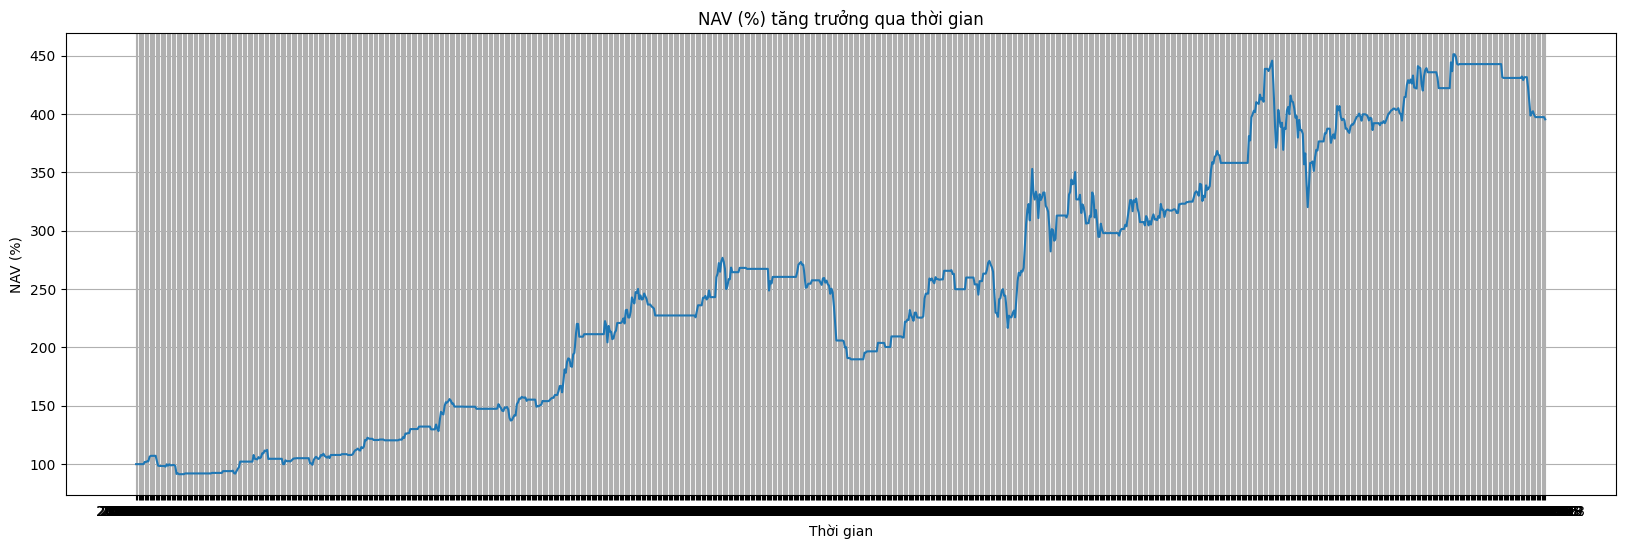

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
sns.lineplot(x='time', y='NAV', data=merged_df)
plt.title('NAV (%) tăng trưởng qua thời gian')
plt.xlabel('Thời gian')
plt.ylabel('NAV (%)')
plt.grid(True)
plt.savefig('net_worth_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

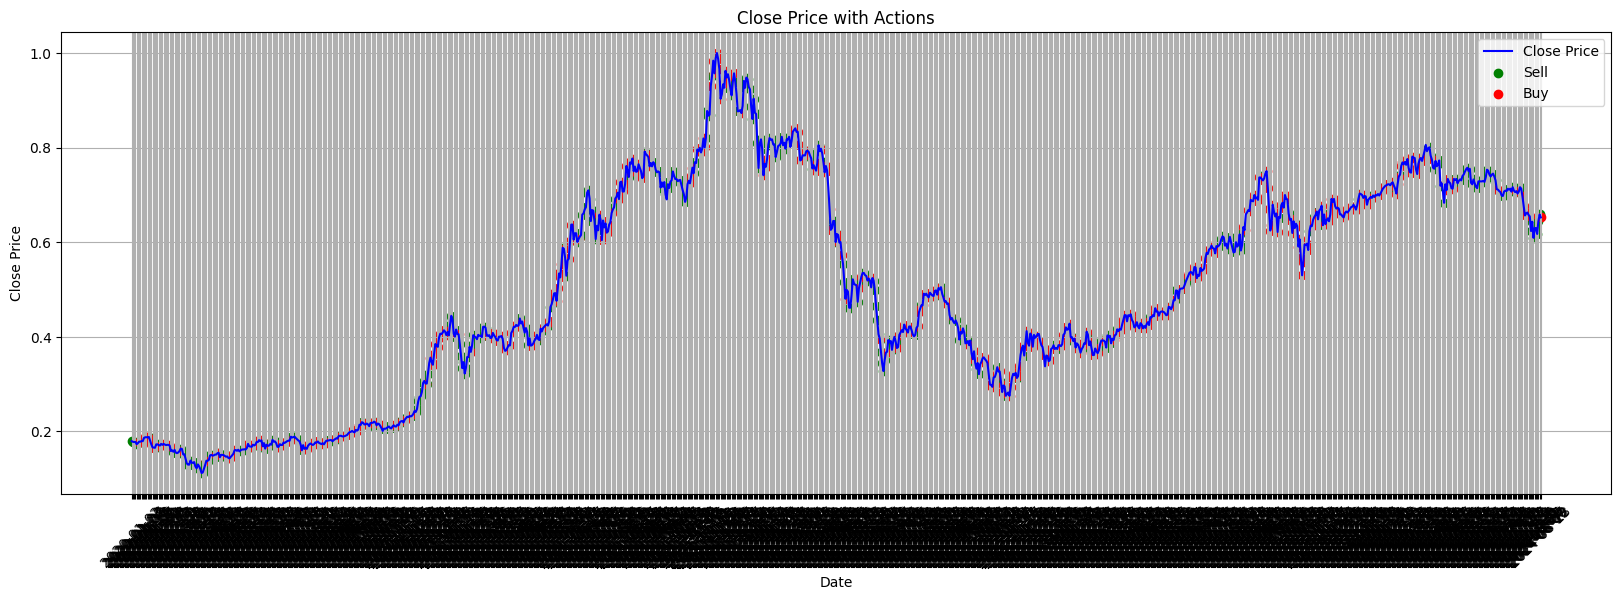

In [7]:
# Plot
plt.figure(figsize=(20, 6))

# Plotting close price
sns.lineplot(x='time', y='close', data=merged_df, color='blue', label='Close Price')

# Plotting buy/sell markers
for action in merged_df['actions'].unique():
    action_df = merged_df[merged_df['actions'] == action]
    if action == 'sell':
        plt.scatter(action_df['time'], action_df['close'], color='green', label='Sell', marker='o')
    elif action == 'buy':
        plt.scatter(action_df['time'], action_df['close'], color='red', label='Buy', marker='o')

# Formatting
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price with Actions')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Save the figure
plt.savefig('close_price_actions.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
